# ClusterMap for STARmap V1_3D

In [1]:
from ClusterMap.clustermap import *
from anndata import AnnData
import tifffile
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io
import math
from tqdm import tqdm

### Read spots and dapi image

In [2]:
### set file folder
filepath='./datasets/STARmap_V1_3D/'

### read dapi: col, row, z
dapi = tifffile.imread(filepath+'DAPI.tiff')
dapi = np.transpose(dapi, (1,2,0))

In [3]:
### read spots
spots = pd.read_csv(filepath+'STARmap_V1_3D_spot_meta_cellid.csv')
spots

reads_genelist_nissl  reads_position_nissl_1  reads_position_nissl_2  \
0                   Slc17a7                       6                      41   
1                   Slc17a7                      10                     995   
2                   Slc17a7                      13                     136   
3                   Slc17a7                      13                    1113   
4                   Slc17a7                      13                    1259   
...                     ...                     ...                     ...   
778799                  Nov                    1331                    1296   
778800                  Nov                    1332                    1294   
778801                  Nov                    1415                    1046   
778802                  Fos                    1260                    1283   
778803                  Fos                    1265                    1290   

        reads_position_nissl_3  
0                            1  
1                            1  
2                            1  
3                            1  
4                            1  
...                        ...  
778799                     100  
778800                     100  
778801                     100  
778802                     100  
778803                     100  

[778804 rows x 4 columns]

In [4]:
spots.columns=['gene_name','spot_location_1','spot_location_2','spot_location_3']

In [5]:
genes=pd.DataFrame(spots['gene_name'].unique())
genes.to_csv(filepath+'genelist.csv', header=False, index=False)

In [6]:
gene=np.zeros((spots.shape[0],1))
for indi,i in enumerate(spots['gene_name']):
    gene[indi]=list(genes[0]).index(i)
gene=gene+1
spots['gene']=gene
spots['gene']=spots['gene'].astype('int')

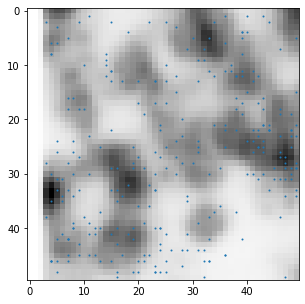

In [7]:
plt.figure(figsize=(5,5))
length=50
plt.imshow(np.sum(dapi,axis=2)[:length,:length],cmap='Greys')
test1=[i[1] and i[0] for i in zip(spots['spot_location_1']<length,spots['spot_location_2']<length)]

plt.scatter(spots['spot_location_1'][test1],spots['spot_location_2'][test1],s=1)

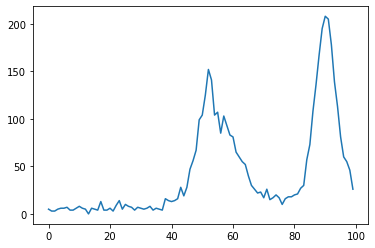

In [8]:
plt.plot(dapi[10,20,:])

In [9]:
### set radius parameters
xy_radius=2
z_radius=9

Text(0.5, 1.0, 'raw data')

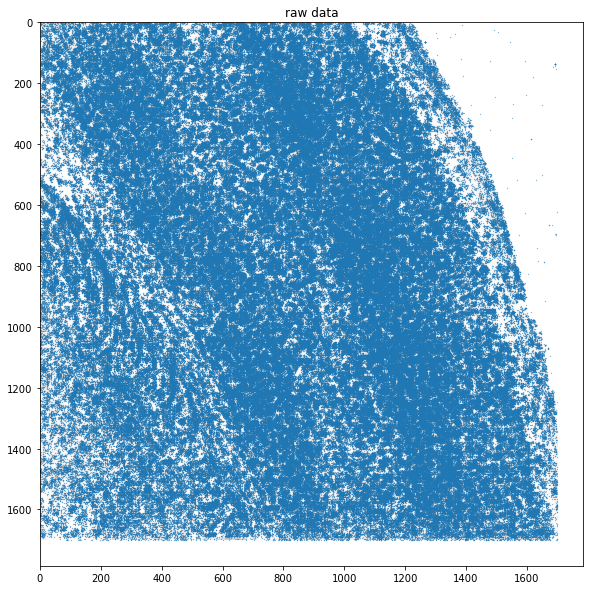

In [10]:
### overview
plt.figure(figsize=(10,10))
length=1000
plt.imshow(np.sum(dapi,axis=2),cmap='Greys')
plt.scatter(spots['spot_location_1'],spots['spot_location_2'],s=0.05)
plt.title('raw data')

### instantiate model

In [11]:
num_gene=np.max(spots['gene'])

gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)
model = ClusterMap(spots=spots, dapi=dapi, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=0,fast_preprocess=True)
model.spots['clustermap']=-1

100%|██████████| 100/100 [00:01<00:00, 77.45it/s]


In [12]:
model.spots

gene_name  spot_location_1  spot_location_2  spot_location_3  gene  \
0        Slc17a7                6               41                1     1   
1        Slc17a7               10              995                1     1   
2        Slc17a7               13              136                1     1   
3        Slc17a7               13             1113                1     1   
4        Slc17a7               13             1259                1     1   
...          ...              ...              ...              ...   ...   
778799       Nov             1331             1296              100     4   
778800       Nov             1332             1294              100     4   
778801       Nov             1415             1046              100     4   
778802       Fos             1260             1283              100    20   
778803       Fos             1265             1290              100    20   

        clustermap  
0               -1  
1               -1  
2               -1  
3               -1  
4               -1  
...            ...  
778799          -1  
778800          -1  
778801          -1  
778802          -1  
778803          -1  

[778804 rows x 6 columns]

### split data into small tiles if input is large

In [13]:
###split
img = dapi
window_size=400
label_img = get_img(img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))
out = split(img, label_img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))

Split finished: 25 tiles


Text(0.5, 1.0, 'splitted tile: 3')

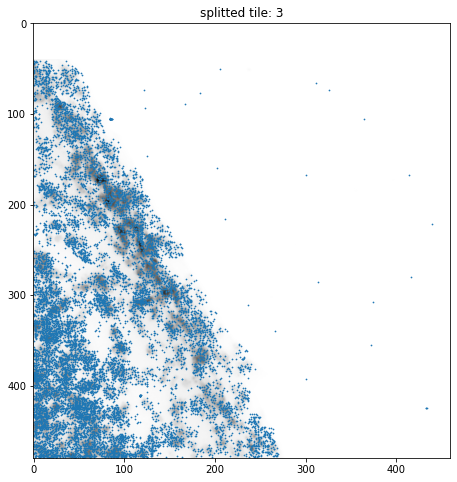

In [16]:
###plot a tile
tile_num=3
plt.figure(figsize=(8,8))
plt.imshow(np.sum(out.loc[tile_num,'img'],axis=2),cmap='Greys')

plt.scatter(out.loc[tile_num,'spots']['spot_location_1'],
            out.loc[tile_num,'spots']['spot_location_2'],s=0.51)
plt.title(f'splitted tile: {tile_num}')

### cell segmentation on each tile

In [17]:
spots_tile=out.loc[tile_num,'spots']

In [18]:
%%time

### process each tile
pct_filter=0.1
cell_info={'cellid':[],'cell_center':[]}

for tile_num in range(out.shape[0])[4:]:
    print(f'tile: {tile_num}')
    spots_tile=out.loc[tile_num,'spots']
    dapi_tile=out.loc[tile_num,'img']
    
    ### instantiate model
    model_tile = ClusterMap(spots=spots_tile, dapi=dapi_tile, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=z_radius,fast_preprocess=False)
    
    ###preprocessing
    model_tile.preprocess(dapi_grid_interval=3,pct_filter=pct_filter)
    break
  

tile: 4


100%|██████████| 100/100 [00:01<00:00, 77.08it/s]


CPU times: user 2.03 s, sys: 80.1 ms, total: 2.11 s
Wall time: 2.12 s


In [19]:
### segmentation
model_tile.min_spot_per_cell=5
model_tile.segmentation(cell_num_threshold=0.001,dapi_grid_interval=3,add_dapi=True,use_genedis=True)
    

After denoising, mRNA spots: 22
Computing NGC coordinates


22it [00:00, 14742.72it/s]


After adding DAPI points, all spots:233453
DPC
  Compute spatial distance


233453it [00:02, 83888.36it/s]


  Compute genetic distance


233453it [00:07, 29371.78it/s]


  Compute density rho and the nearest distance


KeyboardInterrupt: 

In [27]:
model_tile.cellcenter_unique[:,0]

array([[349,  54,  24],
       [179,  78,   2],
       [218,  93,  21],
       ...,
       [219, 348,  93],
       [222, 465,  99],
       [255, 315,  93]])

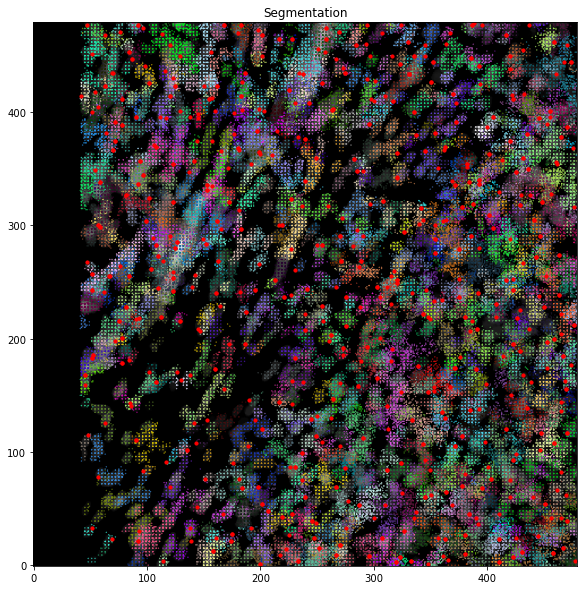

In [31]:
### plot preprocessing results
model_tile.plot_segmentation(figsize=(10,10),s=0.1,plot_dapi=True,show=False )
plt.scatter(model_tile.cellcenter_unique[:,1],
           model_tile.cellcenter_unique[:,0],c='r',s=10)
plt.show()

In [22]:
cell_num_threshold=0.01
dapi_grid_interval=2
add_dapi=True
use_genedis=True

In [23]:
self=model_tile

In [24]:
spots_denoised = self.spots.loc[self.spots['is_noise']==0,:].copy()
spots_denoised.reset_index(inplace=True)
print(f'After denoising, mRNA spots: {spots_denoised.shape[0]}')

print('Computing NGC coordinates')
ngc = NGC(self, spots_denoised)

After denoising, mRNA spots: 45349
Computing NGC coordinates


45349it [00:00, 122964.25it/s]


In [25]:
dapi_binary=self.dapi_binary
num_dims=self.num_dims

In [26]:
sampling_mat = np.zeros(dapi_binary.shape)

In [27]:
for ii,jj,kk in product(range(sampling_mat.shape[0]), range(sampling_mat.shape[1]),range(sampling_mat.shape[2])):
    if ii%dapi_grid_interval==0 and jj%dapi_grid_interval==0 and kk%dapi_grid_interval==0:
        sampling_mat[ii,jj,kk] = 1
dapi_sampled = dapi_binary*sampling_mat
dapi_coord = np.argwhere(dapi_sampled > 0)
spots_points = spots_denoised.loc[:, ['spot_location_2', 'spot_location_1', 'spot_location_3']]

In [166]:
dapi_coord.shape

(263408, 3)

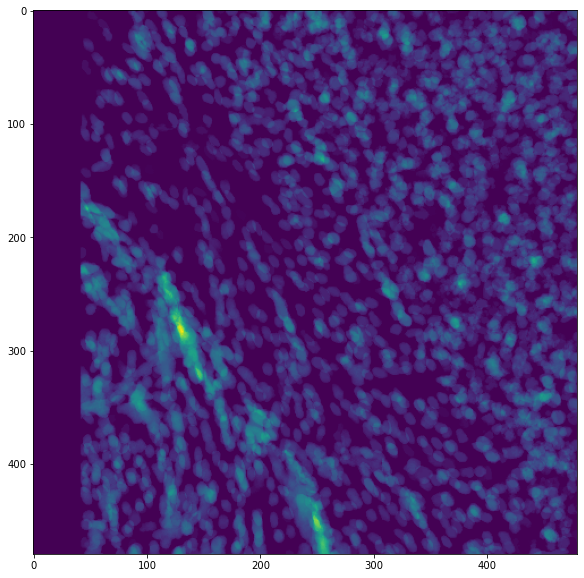

In [175]:
plt.figure(figsize=(10,10))
plt.imshow(np.sum(dapi_binary,axis=2))
plt.scatter(dapi_coord[:,1],dapi_coord[:,0],s=0.000001,c='r')

In [153]:
knn = NearestNeighbors(n_neighbors=1)
knn.fit(spots_points)
neigh_ind = knn.kneighbors(dapi_coord, 1, return_distance=False)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

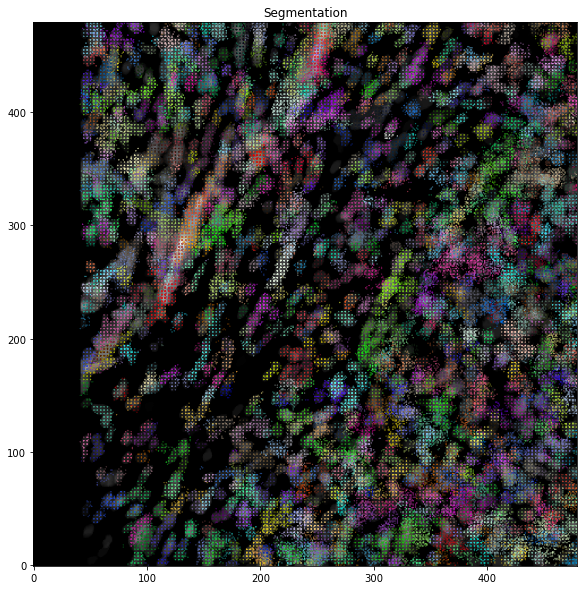

In [142]:
### plot cell segmentation results in spots (colored by cells)
model_tile.plot_segmentation(figsize=(10,10),s=0.05,plot_with_dapi=True,plot_dapi=True, show=False)
#     plt.scatter(model_tile.cellcenter[:,1],model_tile.cellcenter[:,0],c='r',s=3)
    

In [ ]:


#     ### stitch tiles together
#     model_tile.spots.loc[model_tile.spots['clustermap']>=0,'clustermap']+=max(model.spots['clustermap'])+1
#     model.spots.loc[model_tile.spots['index'],'clustermap']=list(model_tile.spots['clustermap'])
   

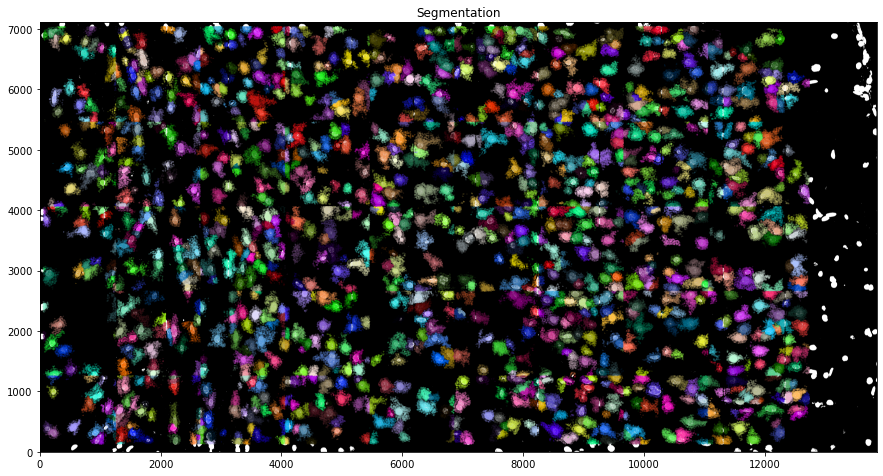

In [19]:
### plot cell segmentation results in spots (colored by cells)
model.plot_segmentation(figsize=(15,8),s=0.005,plot_with_dapi=False,plot_dapi=True, show=False)
plt.show()

### Save cell segmentation results

In [10]:
path_save = filepath+'spots_all.csv'
model.save_segmentation(path_save)

### Perform cell typing (based on Scanpy package)

In [6]:
path_save = filepath+'spots_all.csv'
savespots=pd.read_csv(path_save)
model.spots=savespots
# model.cellcenter = np.genfromtxt(filepath+"cellcenter.csv", delimiter=',')

In [7]:
model.spots

spot_location_1  spot_location_2  spot_location_3  \
0                     59              554                1   
1                     73              478                1   
2                     73              665                1   
3                     79              321                1   
4                     80              197                1   
...                  ...              ...              ...   
1281106            13657             6731               36   
1281107            13724             6548               36   
1281108            13733             6393               36   
1281109            13580             6807               37   
1281110            13592             6833               37   

        spot_image_position  gene  spot_cell_id  clustermap  
0                        V1   979            -2        -1.0  
1                        V1   492            -2        38.0  
2                        V1   340            -2        -1.0  
3                        V1   548            -2        38.0  
4                        V1   979            -2        -1.0  
...                     ...   ...           ...         ...  
1281106                  V1   468          1473        -1.0  
1281107                  V1    57          1399        -1.0  
1281108                  V1   722          1339        -1.0  
1281109                  V1   911          1457        -1.0  
1281110                  V1   798          1492        -1.0  

[1281111 rows x 7 columns]

In [8]:
cellid='clustermap'
geneid='gene'
num_gene=np.max(spots['gene'])
gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)

cluster_method='leiden'

In [9]:
model.create_cell_adata(cellid,geneid,gene_list,genes,num_dims)

/Users/yichunhe/opt/anaconda3/envs/workEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


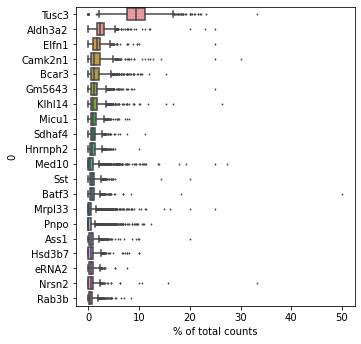

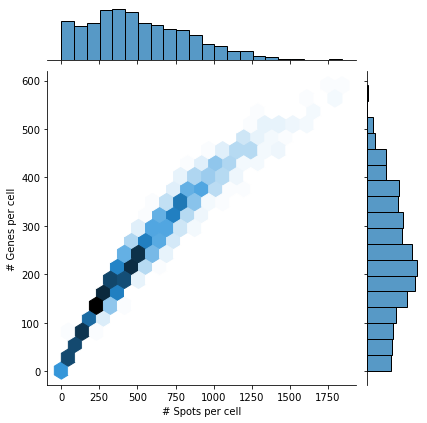

Leiden clustering


In [10]:
model.cell_typing(cluster_method=cluster_method)

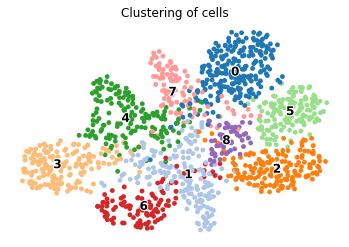

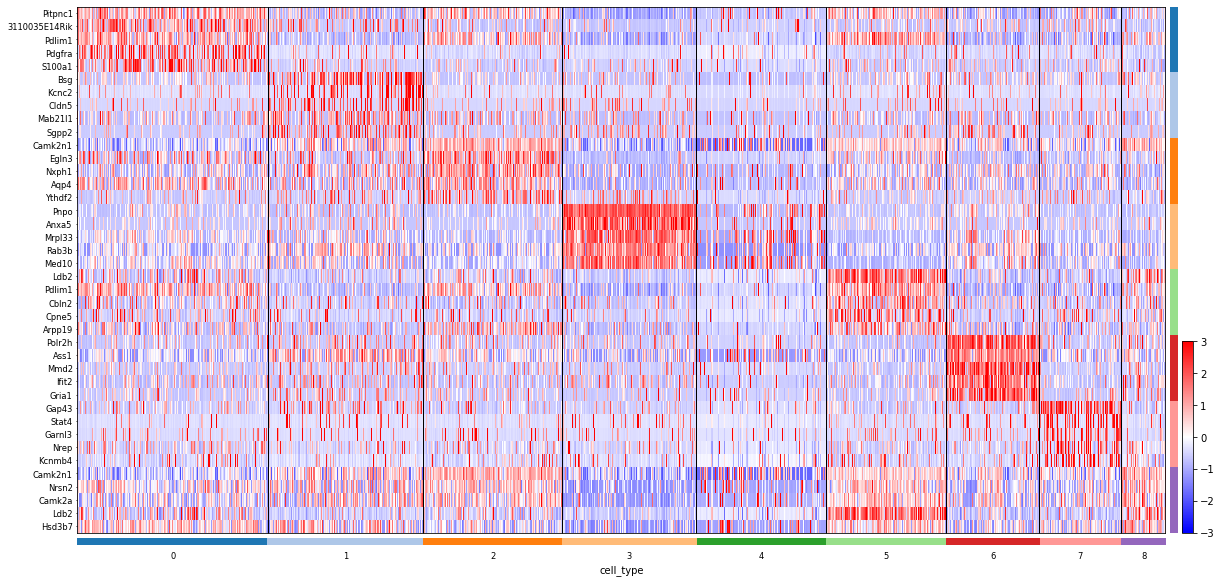

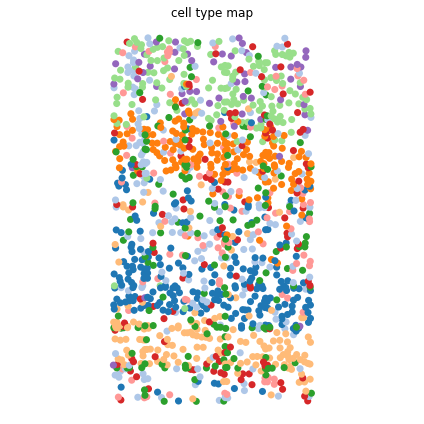

In [11]:
cluster_pl=model.plot_cell_typing()

In [12]:
model.map_cell_type_to_spots(cellid)

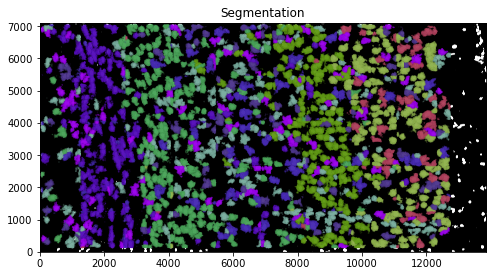

In [13]:
### plot cell segmentation results in spots (colored by cells)
model.plot_segmentation(figsize=(8,8),method='cell_type',s=0.005,plot_with_dapi=True,plot_dapi=True, show=False)
plt.show()